,temperatura,conductividad,"Tiempo, min"
0,25.1,0.1,0
1,25.0,0.2,3
2,24.8,0.1,6
3,24.9,0.2,9
4,24.9,0.1,12
5,25.0,0.2,15


,temperatura,conductividad,"Tiempo, min"
0,30.1,0.3,0
1,30.0,0.4,3
2,29.8,0.3,6
3,29.9,0.4,9
4,29.9,0.3,12
5,30.0,0.4,15


,temperatura,conductividad,"Tiempo, min"
0,35.1,0.5,0
1,35.0,0.6,3
2,34.8,0.5,6
3,34.9,0.6,9
4,34.9,0.5,12
5,35.0,0.6,15


,"Tiempo, min",conductividad,Temperatura,at,ct,xa,xe
0,0,0.10,25.1,-0.365486,0.390486,15.619424,15.619424
1,3,0.20,25.0,-0.692925,0.717925,28.717001,28.717001
2,6,0.10,24.8,-0.365486,0.390486,15.619424,15.619424
3,9,0.20,24.9,-0.692925,0.717925,28.717001,28.717001
4,12,0.10,24.9,-0.365486,0.390486,15.619424,15.619424
5,15,0.20,25.0,-0.692925,0.717925,28.717001,28.717001
6,Media,0.15,7.5,-0.529205,0.554205,22.168212,22.168212


,"Tiempo, min",conductividad,Temperatura,at,ct,xa,xe
0,0,0.30,30.1,-1.020364,1.045364,41.814578,41.814578
1,3,0.40,30.0,-1.347804,1.372804,54.912155,54.912155
2,6,0.30,29.8,-1.020364,1.045364,41.814578,41.814578
3,9,0.40,29.9,-1.347804,1.372804,54.912155,54.912155
4,12,0.30,29.9,-1.020364,1.045364,41.814578,41.814578
5,15,0.40,30.0,-1.347804,1.372804,54.912155,54.912155
6,Media,0.35,7.5,-1.184084,1.209084,48.363366,48.363366


,"Tiempo, min",conductividad,Temperatura,at,ct,xa,xe
0,0,0.50,35.1,-1.675243,1.700243,68.009731,68.009731
1,3,0.60,35.0,-2.002683,2.027683,81.107308,81.107308
2,6,0.50,34.8,-1.675243,1.700243,68.009731,68.009731
3,9,0.60,34.9,-2.002683,2.027683,81.107308,81.107308
4,12,0.50,34.9,-1.675243,1.700243,68.009731,68.009731
5,15,0.60,35.0,-2.002683,2.027683,81.107308,81.107308
6,Media,0.55,7.5,-1.838963,1.863963,74.558520,74.558520


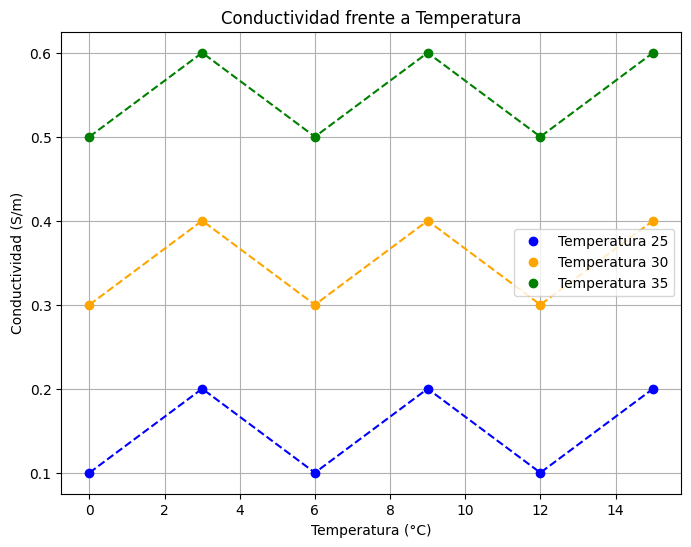

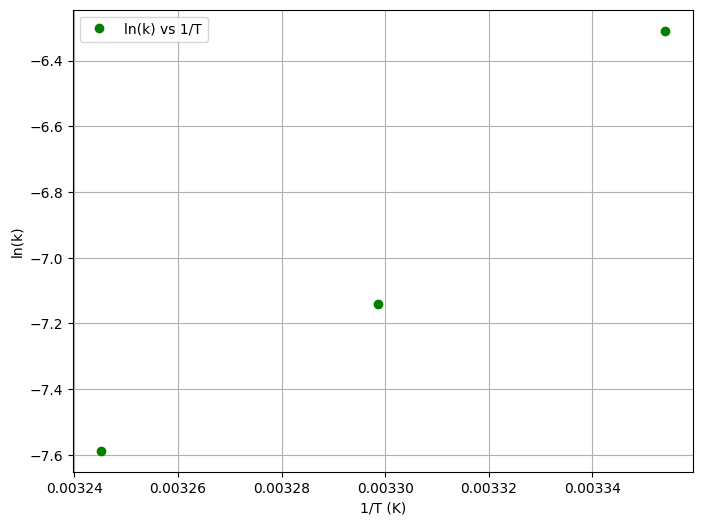

,Ea J/mol,A L/mol s
0,-0.000689,1.003888


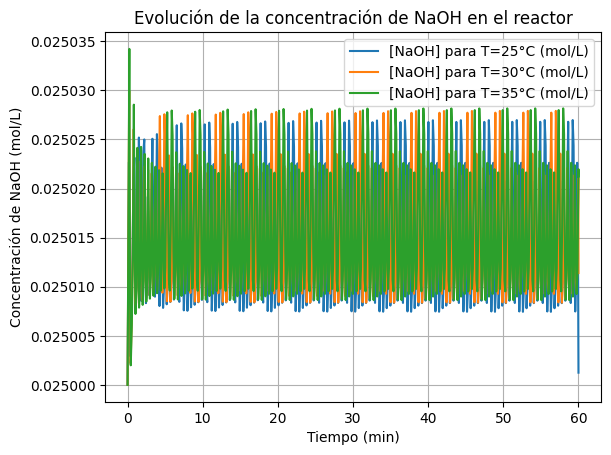

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from scipy.stats import linregress
from scipy.integrate import solve_ivp


Temperatura_objetivo = [25, 30, 35]
tiempos = [0, 3, 6, 9, 12, 15]

Fa = 40  # ml/min
Fb = 40  # ml/min
Au = 0.05
bu = 0.05
c0 = 0.0
V = 1.45  # Volumen del reactor en litros
T0 = 25.0  # Temperatura inicial
uno_partido_T = []
valor_k = []
ln_k = []
medidas = [
    {'temperatura': [25.1, 25, 24.8, 24.9, 24.9, 25],
     'conductividad': [0.1, 0.2, 0.1, 0.2, 0.1, 0.2]},
    {'temperatura': [30.1, 30, 29.8, 29.9, 29.9, 30],
     'conductividad': [0.3, 0.4, 0.3, 0.4, 0.3, 0.4]},
    {'temperatura': [35.1, 35, 34.8, 34.9, 34.9, 35],
     'conductividad': [0.5, 0.6, 0.5, 0.6, 0.5, 0.6]},
]

dataframes_medidas = {}
for i, medida in enumerate(medidas):
    medida['Tiempo, min'] = tiempos
    df = pd.DataFrame(medida)

    # Asignar un nombre específico al DataFrame basado en la temperatura objetivo
    nombre_df = f"Temperatura_{Temperatura_objetivo[i]}"
    dataframes_medidas[nombre_df] = df
    display(dataframes_medidas[nombre_df])

plt.figure(figsize=(8, 6))
colores = ['blue', 'orange', 'green']

# Usar enumerate para acceder al índice y las medidas
for i, medida in enumerate(medidas):
    a0 = Fa / (Fa + Fb) * Au
    b0 = Fb / (Fa + Fb) * bu
    Temperatura = Temperatura_objetivo[i]  # Usar el índice i

    if b0 < a0:
        cinf = b0 
    else:
        cinf = a0

    alpha_c_inf = 0.07 * (1 + 0.0284 * (T0 - 294)) * cinf
    alpha_a0 = 0.195 * (1 + 0.0184 * (T0 - 294)) * a0

    if c0 == 0:
        Alpha0 = alpha_a0 

    ainf = a0 - b0 if a0 >= b0 else 0
    alpha_a_inf = 0.195 * (1 + 0.0184 * (T0 - 294)) * ainf if ainf != 0 else 0
    alpha_inf = alpha_c_inf + alpha_a_inf

    Temp = medida['temperatura']
    C = medida['conductividad']
    T = medida['Tiempo, min']

    at = []
    ct = []
    xa = []
    xe = []

    for c, temp, t in zip(C, Temp, T):
        at_val = (ainf - a0) * ((Alpha0 - c) / (Alpha0 - alpha_inf)) + a0
        ct_val = cinf * ((Alpha0 - c) / (Alpha0 - alpha_inf))
        xa_val = (a0 - at_val) / a0
        xe_val = ct_val / cinf
        
        # Almacenar los resultados
        at.append(at_val)
        ct.append(ct_val)
        xa.append(xa_val)
        xe.append(xe_val)
    
    # Crear un DataFrame con los resultados del bucle
    df_result = pd.DataFrame({
        'Tiempo, min': T,
        'conductividad': C,
        'Temperatura': Temp,
        'at': at,
        'ct': ct,
        'xa': xa,
        'xe': xe
    })
    # Calcular la media de las columnas
    media_at = df_result['at'].mean()
    media_ct = df_result['ct'].mean()
    media_xa = df_result['xa'].mean()
    media_xe = df_result['xe'].mean()
    media_Tiempo = df_result['Tiempo, min'].mean()
    media_conductividad = df_result['conductividad'].mean()

    # Agregar fila de medias al final del DataFrame
    df_media = pd.DataFrame({
        'Tiempo, min': ['Media'],
        'conductividad': [media_conductividad],  # Ningún valor para la columna de conductividad
        'Temperatura': [media_Tiempo],  # Ningún valor para la columna de Temperatura
        'at': [media_at],
        'ct': [media_ct],
        'xa': [media_xa],
        'xe': [media_xe]
    })

    # Concatenar la fila de medias al DataFrame original
    df_result = pd.concat([df_result, df_media], ignore_index=True)
    display(df_result)
    valor_media_at = df_result['at'].iloc[-1]
    k = ((Fa / 60000 + (Fb / 60000)) / V) * ((a0 - valor_media_at) / (valor_media_at ** 2))  # m^-1 s^-1
    valor_k = np.append(valor_k, k)  # Almacenar en valor_k
    uno_partido_T.append(1/(Temperatura_objetivo[i] + 273.15))
    ln_k.append(np.log(k))
    plt.plot(T, C, marker='o', linestyle='None', color=colores[i], label=f"Temperatura {Temperatura}")  # Cambia el label
    plt.plot(T, C, linestyle='--', color=colores[i])
    

# Configurar el título y etiquetas de la gráfica
plt.title('Conductividad frente a Temperatura')
plt.xlabel('Temperatura (°C)')
plt.ylabel('Conductividad (S/m)')
plt.legend()  # Añadir la leyenda para identificar cada serie
plt.grid(True)  # Añadir una cuadrícula para mayor claridad
plt.show()  # Mostrar la gráfica

# Gráfica de ln(k) vs 1/T
plt.figure(figsize=(8, 6))
plt.plot(uno_partido_T, ln_k, marker='o', linestyle='None', color=colores[i], label='ln(k) vs 1/T')
plt.xlabel('1/T (K)')
plt.ylabel('ln(k)')
plt.legend()
plt.grid(True)
plt.show()

slope, intercept, r_value, _, std_err = linregress(ln_k, uno_partido_T)
R = 8.314
Ea = -slope * R
A = np.exp(intercept)

df_arrhenius = pd.DataFrame({
    'Ea J/mol': [Ea],
    'A L/mol s': [A]
})
display(df_arrhenius)
def reactor_edo(t, a, Fa, k, V, a0):
    da_dt = (Fa / V) * (a0 - a) - k * a
    return da_dt
for j in range(len(valor_k)):
    temperatura = Temperatura_objetivo[j]
    t_span = [0, 60]
    k_j = valor_k[j]  # Usar el valor correspondiente de k
    sol = solve_ivp(reactor_edo, t_span, [a0], args=(Fa, k_j, V, a0), dense_output=True)
    t = sol.t
    a_t = sol.y[0]
    plt.plot(t, a_t, label=f'[NaOH] para T={temperatura}°C (mol/L)')  

plt.xlabel('Tiempo (min)')
plt.ylabel('Concentración de NaOH (mol/L)')
plt.title('Evolución de la concentración de NaOH en el reactor')
plt.legend()
plt.grid(True)
plt.show()
